In [4]:
import wandb
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager as fm
font_path = 'analyses/font_arial.ttf'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 12})

# Get wandb run history
api = wandb.Api()
wandb_path = os.path.join("..", "wandb")

In [2]:
p_electrodes_per_streams = [0.5, 0.6, 0.7, 0.8, 0.9]
random_strings = ["PPS_1", "PPS_2", "PPS_3", "WD_1", "WD_2", "WD_3"]

# Initialize histories dict
histories = {pps: [] for pps in p_electrodes_per_streams}

# Generate all run IDs and collect histories
for pps in p_electrodes_per_streams:
    for rs in random_strings:
        pps_suff = f"_pps{pps}" if pps != 0.5 else ""
        run_id = f"M_nst8_iN{pps_suff}_dm192_nh12_nl5_5_dr0.2_bs100_wd0.0_lr0.002_optMuon_r{rs}"
        
        runs = api.runs("andrii-mit/mini_bfm_exp", filters={"display_name": run_id})
        if len(runs) > 0:
            run = runs[0]
            history = run.history()
            if history['_step'].max() == 99:  # Only include if trained for full 100 epochs
                histories[pps].append(history)

for pps in p_electrodes_per_streams:
    print(f"pps {pps}: {len(histories[pps])} runs")

pps 0.5: 5 runs
pps 0.6: 2 runs
pps 0.7: 3 runs
pps 0.8: 3 runs
pps 0.9: 2 runs


In [34]:
metrics = ['train_loss', 'test_loss', 'eval_auroc/average_speech', 'eval_auroc/average_volume']
metric_names = ['Training Loss', 'Test Loss', 'Decoding Speech AUROC', 'Decoding Volume AUROC']
n_last_measurements = 3

# Initialize results dictionary
results = {pps: {metric: [] for metric in metrics} 
          for pps in p_electrodes_per_streams}

# Calculate means for each run
for pps in p_electrodes_per_streams:
    for history in histories[pps]:
        for metric in metrics:
            results[pps][metric].append(history[metric].iloc[-n_last_measurements:].mean())

# Print results
for pps in p_electrodes_per_streams:
    print(f"\npps {pps}:")
    for metric in metrics:
        values = results[pps][metric]
        if values:
            mean = sum(values) / len(values)
            print(f"{metric}: {mean:.4f} (across {len(values)} runs)")



pps 0.5:
train_loss: 0.2964 (across 5 runs)
test_loss: 0.4350 (across 5 runs)
eval_auroc/average_speech: 0.8437 (across 5 runs)
eval_auroc/average_volume: 0.7199 (across 5 runs)

pps 0.6:
train_loss: 0.1800 (across 2 runs)
test_loss: 0.5078 (across 2 runs)
eval_auroc/average_speech: 0.8449 (across 2 runs)
eval_auroc/average_volume: 0.7088 (across 2 runs)

pps 0.7:
train_loss: 0.1040 (across 3 runs)
test_loss: 0.8585 (across 3 runs)
eval_auroc/average_speech: 0.8147 (across 3 runs)
eval_auroc/average_volume: 0.6607 (across 3 runs)

pps 0.8:
train_loss: 0.0579 (across 3 runs)
test_loss: 1.5365 (across 3 runs)
eval_auroc/average_speech: 0.8021 (across 3 runs)
eval_auroc/average_volume: 0.6530 (across 3 runs)

pps 0.9:
train_loss: 0.0350 (across 2 runs)
test_loss: 2.9167 (across 2 runs)
eval_auroc/average_speech: 0.7832 (across 2 runs)
eval_auroc/average_volume: 0.6282 (across 2 runs)


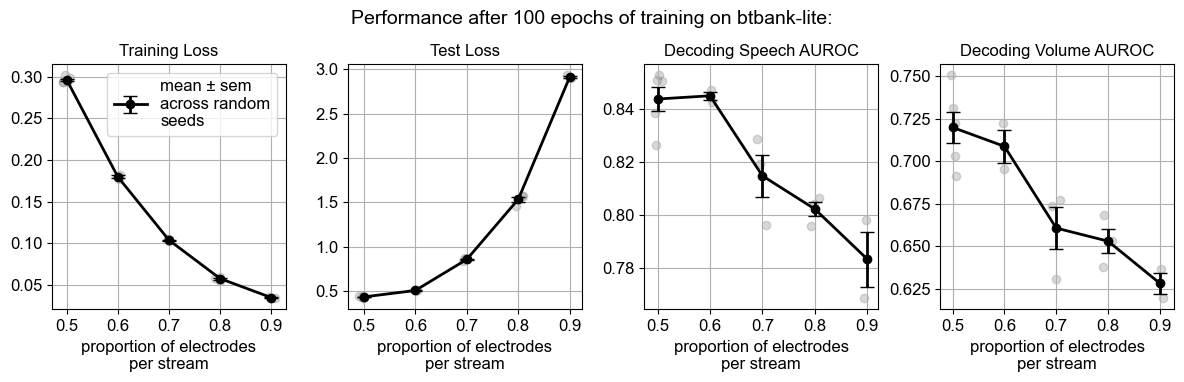

In [36]:
# Set error bar type ('std' for standard deviation or 'sem' for standard error of mean)
error_type = 'sem'

fig, axes = plt.subplots(1, len(metrics), figsize=(3*len(metrics), 4))

for i, metric in enumerate(metrics):
    means = []
    errors = []
    ps = []
    all_values = []
    all_ps = []
    
    for pps in p_electrodes_per_streams:
        values = results[pps][metric]
        if values:  # Only include if we have data
            means.append(np.mean(values))
            if error_type == 'std':
                errors.append(np.std(values))
            else:  # sem
                errors.append(np.std(values) / np.sqrt(len(values)))
            ps.append(pps)
            # Store individual points
            all_values.extend(values)
            all_ps.extend([pps] * len(values))
    
    # Plot individual points with some jitter and transparency
    jitter = 0.01
    axes[i].scatter(
        [p + np.random.uniform(-jitter, jitter) for p in all_ps],
        all_values,
        alpha=0.3,
        color='gray',
        zorder=1
    )
    
    # Plot mean and error bars on top
    error_label = 'mean ± std' if error_type == 'std' else 'mean ± sem'
    error_label += '\nacross random\nseeds'
    axes[i].errorbar(ps, means, yerr=errors, marker='o', capsize=5, 
                    color='black', zorder=2, label=error_label,
                    linewidth=2)
    
    axes[i].set_xticks(p_electrodes_per_streams)
    axes[i].set_xlabel('proportion of electrodes\nper stream')
    #axes[i].set_ylabel('Value')
    axes[i].set_title(metric_names[i], color='black', fontsize=12)
    axes[i].grid(True)
    if i==0: axes[i].legend()

plt.suptitle('Performance after 100 epochs of training on btbank-lite:', color='black', fontsize=14, y=0.95)
plt.tight_layout()
plt.savefig('analyses/exp_pps.pdf', bbox_inches='tight', dpi=300)
plt.show()
